In [1]:
%load_ext autoreload
%autoreload 2

%load_ext line_profiler

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import pickle

from chemistry import Molecule
from util import score
from pprint import pprint

In [3]:
with open('../data/molecules.pickle', 'rb') as f:
    molecules = pickle.load(f)

In [4]:
structures = pd.read_feather('../data/structures.feather')
labelled = pd.read_feather('../data/train.feather')
unlabelled = pd.read_feather('../data/test.feather')

In [5]:
molecules['dsgdb9nsd_000001']

Name: dsgdb9nsd_000001
Atoms:
  C 0: [-0.01269814  1.0858041   0.008001  ]
  H 1: [ 0.00215042 -0.00603132  0.00197612]
  H 2: [1.0117308e+00 1.4637512e+00 2.7657481e-04]
  H 3: [-0.54081506  1.4475266  -0.8766437 ]
  H 4: [-0.5238136  1.4379326  0.9063973]
Bonds:
  C(0) - H(1)
  C(0) - H(2)
  C(0) - H(3)
  C(0) - H(4)


In [6]:
molecules['dsgdb9nsd_000001'].bonds

{(0, 1): Bond(dist=1.0919529, valency=1, strength=411),
 (0, 2): Bond(dist=1.0919516, valency=1, strength=411),
 (0, 3): Bond(dist=1.0919464, valency=1, strength=411),
 (0, 4): Bond(dist=1.0919476, valency=1, strength=411)}

In [7]:
labelled.head(n=10)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.807602
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.257000
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.254800
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.254300
4,4,dsgdb9nsd_000001,2,0,1JHC,84.807404
5,5,dsgdb9nsd_000001,2,3,2JHH,-11.254100
6,6,dsgdb9nsd_000001,2,4,2JHH,-11.254800
7,7,dsgdb9nsd_000001,3,0,1JHC,84.809303
8,8,dsgdb9nsd_000001,3,4,2JHH,-11.254300
9,9,dsgdb9nsd_000001,4,0,1JHC,84.809502


# Inputs

* bond type
  * One hot encoding
* bond length
* atom1 position
* atom2 position
* atom3 position
* atom4 position

def merge(data):
    data.copy()
    
    m0 = data.merge(structures, left_on=['molecule_name', 'atom_index_0'], right_on=['molecule_name', 'atom_index'], suffixes=('0', '0'))
    m1 = data.merge(structures, left_on=['molecule_name', 'atom_index_1'], right_on=['molecule_name', 'atom_index'], suffixes=('1', '1'))
    
    l0 = m0[['x', 'y', 'z']]
    l1 = m1[['x', 'y', 'z']]
    d = l0 - l1
    d2 = d * d
    dist2 = d2.x + d2.y + d2.z
    dist = dist2.apply(np.sqrt)
    dist.name = 'distance'
    
    merged = data.join(dist)
    merged['atom_0'] = m0.atom
    merged['atom_1'] = m1.atom
    
    return merged

labelled_merged = merge(labelled)
unlabelled_merged = merge(unlabelled)

min_dist = min(labelled_merged.distance.min(), unlabelled_merged.distance.min())
max_dist = max(labelled_merged.distance.max(), unlabelled_merged.distance.max())

min_coeff = labelled_merged.scalar_coupling_constant.min()
max_coeff = labelled_merged.scalar_coupling_constant.max()

offset = min_coeff
scale = max_coeff - min_coeff

labelled_merged['norm_distance'] = (labelled_merged.distance - min_dist) / (max_dist - min_dist)
unlabelled_merged['norm_distance'] = (unlabelled_merged.distance - min_dist) / (max_dist - min_dist)

labelled_merged['norm_scc'] = (labelled_merged.scalar_coupling_constant - min_coeff) / (max_coeff - min_coeff)

In [8]:
min_coeff = labelled.scalar_coupling_constant.min()
max_coeff = labelled.scalar_coupling_constant.max()

offset = min_coeff
scale = max_coeff - min_coeff

labelled['norm_scc'] = (labelled.scalar_coupling_constant - min_coeff) / (max_coeff - min_coeff)

In [9]:
types = labelled.type.unique()
atoms = structures.atom.unique()

index = 0
type_index = {}
for t in types:
    type_index[t] = index
    index += 1

index = 0
atom_index = {}
for a in atoms:
    atom_index[a] = index
    index += 1

In [10]:
def partition_labelled(data, count=None, train_frac=0.7):
    n_labelled = count if count is not None else len(labelled)
    n_train = int(n_labelled * train_frac)
    n_test = n_labelled - n_train
    indices = np.arange(0, n_labelled)
    np.random.shuffle(indices)
    
    train_indices = indices[0:n_train]
    test_indices = indices[n_train:]
    
    train = data.iloc[train_indices, :]
    test = data.iloc[test_indices, :]

    return train, test

def make_input(data):
    n = len(data)
    

    coupling_input = np.zeros((len(types), n), dtype='float32')
    atom_input = [None] * 4
    for i in range(len(atom_input)):
        atom_input[i] = np.zeros((len(atoms), n), dtype='float32')

    bond_input = [None] * 3
    for i in range(len(bond_input)):
        bond_input[i] = np.zeros((3, n), dtype='float32')

    for t in type_index:
        coupling_input[type_index[t], data.type == t] = 1

    for i, row in enumerate(data.itertuples()):
        # coupling_input[type_index[row.type], i] = 1
        
        m = molecules[row.molecule_name]
        bonds = m.bonds
        
        path = m.compute_path(row.atom_index_0, row.atom_index_1)
        syms = [m.symbols[idx] for idx in path]
        
        atom_input[0][atom_index[syms[0]], i]  = 1
        
        try:
            i0 = path[0]
            for j, i1 in enumerate(path[1:]):
                b = bonds.get((i0, i1), None)
                if b is None:
                    b = bonds.get((i1, i0), None)
                if b is None:
                    print(f'Unable to resolve bond - path = {path}, bond = {(i0, i1)})')
                    i0 = i1
                    continue

                j2 = j + 1

                bond_input[j][:, i] = [b.dist, b.valency, b.strength]            
                atom_input[j2][atom_index[syms[j2]], i] = 1

                i0 = i1
        except:
            pass
            
    return (coupling_input, atom_input, bond_input)

def make_output(data):
    n = len(data)
    output = np.zeros(n, dtype='float32')
    #output[:] = data.norm_scc
    output[:] = data.scalar_coupling_constant
        
    return output

def combine_inputs(inputs_tuple):
    coupling_input, atom_input, bond_input = inputs_tuple
    
    inputs = [coupling_input]
    inputs.extend(atom_input)
    inputs.extend(bond_input)
    
    w, h = coupling_input.shape
    for a in atom_input:
        w += a.shape[0]
    for a in bond_input:
        w += a.shape[0]
    
    input = np.empty((w, h), dtype='float32')
    i = 0
    for a in inputs:
        w, _ = a.shape
        input[i:i + w, :] = a
        i += w
    
    return input.T

In [11]:
labelled.type.unique()

[1JHC, 2JHH, 1JHN, 2JHN, 2JHC, 3JHH, 3JHC, 3JHN]
Categories (8, object): [1JHC, 2JHH, 1JHN, 2JHN, 2JHC, 3JHH, 3JHC, 3JHN]

1JHC 1.4998853564317134
2JHH 0.3975515271073431
1JHN 1.0610196207233398
2JHN -0.1388324158500946
2JHC 0.32646706098728384
3JHH 1.1858974112405696
3JHC 0.6119855727793652
3JHN -0.4237267433694122


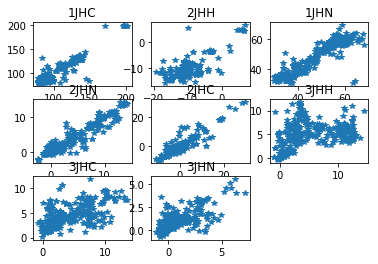

In [13]:
from sklearn.svm import SVR,LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
    
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

models = {}
types = labelled.type.unique()

def test(count=1000, max_iter=1000):
    plt.figure()
    for t in types:
        labelled_train, labelled_test = partition_labelled(labelled[labelled.type == t], count)

        labelled_train_input = combine_inputs(make_input(labelled_train))
        labelled_train_output = make_output(labelled_train)

        labelled_test_input = combine_inputs(make_input(labelled_test))
        labelled_test_output = make_output(labelled_test)

        n_train_samples, n_features = labelled_train_input.shape
        n_test_samples, _ = labelled_test_input.shape

        #input_scaler = StandardScaler()
        #output_scaler = StandardScaler()

        #reg = LinearSVR(max_iter=max_iter)
        reg = RandomForestRegressor(n_estimators=100)

        #model = Pipeline(steps=[('scaler', input_scaler), ('reg', reg)])
        model = Pipeline(steps=[('reg', reg)])

        #output_scaler.fit(labelled_train_output.reshape((n_train_samples, 1)))
        #scaled_train_output = output_scaler.transform(labelled_train_output.reshape((n_train_samples, 1))).flatten()
        scaled_train_output = labelled_train_output

        model.fit(labelled_train_input, scaled_train_output)

        #s = model.score(input_scaler.transform(labelled_test_input), output_scaler.transform(labelled_test_output.reshape((n_test_samples, 1))).flatten())
        scaled_output = model.predict(labelled_test_input)
        #output = output_scaler.inverse_transform(scaled_output)
        output = scaled_output

        s = score(labelled_test, labelled_test_output, output)
        
        #pprint(list(zip(labelled_test_output, output)))
        
        plt.subplot(3, 3, type_index[t] + 1)
        plt.plot(labelled_test_output, output, '*')
        plt.title(t)
        print(t, s)
    
    plt.show()
    
test(1000, 10000)

labelled_train, labelled_test = partition_labelled(labelled, 20000)

labelled_train_input = combine_inputs(make_input(labelled_train))
labelled_train_output = make_output(labelled_train)

labelled_test_input = combine_inputs(make_input(labelled_test))
labelled_test_output = make_output(labelled_test)

from sklearn.svm import SVR,LinearSVR

model = LinearSVR()
model.fit(labelled_train_input, labelled_train_output)
print('')
#print(model.predict(test_input))
#print(test_output)
model.score(labelled_test_input, labelled_test_output)

In [ ]:
labelled_train_input = combine_inputs(make_input(labelled.head(10000)))
labelled_train_output = make_output(labelled.head(10000))

labelled_train_input.shape, labelled_train_output.shape

In [ ]:
def create_and_train_models(df, max_iter=1000):
    models = {}
    for t in types:
        df_coupling = df[df.type == t]
        print(f'Training {len(df_coupling)} samples for coupling type {t}')

        input = combine_inputs(make_input(df_coupling))
        output = make_output(df_coupling)

        n_samples, n_features = input.shape

        input_scaler = StandardScaler()
        output_scaler = StandardScaler()

        reg = LinearSVR(max_iter=max_iter)

        model = Pipeline(steps=[('scaler', input_scaler), ('reg', reg)])

        output_scaler.fit(output.reshape((n_samples, 1)))
      
        scaled_output = output_scaler.transform(output.reshape((n_samples, 1))).flatten()
        model.fit(input, scaled_output)
        
        models[t] = model
        
    return models, output_scaler

models, output_scaler = create_and_train_models(labelled, 10000)

In [ ]:
list(models.keys())

In [ ]:
def run_models(df, models, output_scaler):
    out_df = None
    for t in types:
        df_coupling = df[df.type == t]
        print(f'Predicting {len(df_coupling)} samples for coupling type {t}')

        input = combine_inputs(make_input(df_coupling))
        n_samples, n_features = input.shape
    
        if n_samples == 0:
            continue

        id = df_coupling['id']
        scaled_output = models[t].predict(input)
        output = output_scaler.inverse_transform(scaled_output.reshape(n_samples, 1)).flatten()
        
        out_df_coupling = pd.DataFrame(data={'id':id, 'scalar_coupling_constant':output}, index=df_coupling.index)
        
        if out_df is None:
            out_df = out_df_coupling
        else:
            out_df = out_df.append(out_df_coupling).sort_index()

    return out_df.sort_index()
                
output_df = run_models(unlabelled, models, output_scaler)
#output_df

unlabelled_output = model.predict(unlabelled_input)

unlabelled_output

unlabelled_output = unlabelled_output * scale + offset

unlabelled_output

output_df = pd.DataFrame({'id':unlabelled.id, 'scalar_coupling_constant':pd.Series(unlabelled_output, index=unlabelled.index)})

output_df

In [ ]:
output_df.to_csv('../data/pred.csv',index=False)